In [61]:
import torch
from helpers.ann_tools import *
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 3

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# ANNs on staggered grids
We need to develop ANNs which work on staggered grids. It is important to track short waves. Below we show the spatial stencil of ZB20 model on Arakawa C grid:
![figure](Staggered_grid.png)

# ZB20 as ANN

In [80]:
def ZB20(x):
    '''
    x is the vector containing three input features: sh_xy(corner), sh_xx (center), vort_xy(corner)
    They are stacked together to form 3*4 input features
    4 consecutive points describe the stencil 2x2 where 
    the fast index corresponds to zonal ("x") direction (as in MOM6) 
    
    This function is NN, being a part of mapping T = delta^2 * ||X||^2 * NN(X / ||X||)
    with norm being second norm, and delta is the grid step.
    
    The output vector y contains three values Txx, Tyy, Txy with
    du/dt = div(T)
    
    Note that the leftmost dimension is batch, i.e.
    x(:,12), y(:,3)
    
    Note also that here ZB_Scaling is assumed to be 1 and there is no minus.
    It will be included to the kappa in online evaluation
    '''
    if x.shape[1] != 12:
        print('Error')
        return
    sh_xy_h   = x[:,:4].mean(dim=1, keepdims=True)
    sh_xx_q   = x[:,4:8].mean(dim=1, keepdims=True)
    vort_xy_h = x[:,8:].mean(dim=1, keepdims=True)
    sh_xx = x[:,4:5]
    vort_xy = x[:,11:12]
    
    vort_sh = vort_xy_h * sh_xy_h
    sum_sq = 0.5 * (vort_xy_h * vort_xy_h + sh_xy_h * sh_xy_h + sh_xx * sh_xx)
    
    
    y = torch.zeros(x.shape[0],3)
    y[:,0:1] = (-vort_sh + sum_sq)
    y[:,1:2] = (+vort_sh + sum_sq)
    y[:,2:3] = (+vort_xy * sh_xx_q)
    return y

# Testing

In [81]:
D = torch.randn(1)
D_hat = torch.randn(1)
zeta = torch.randn(1)
x = torch.tensor([[D]*4 + [D_hat]*4 + [zeta]*4])

In [82]:
Txx = (-zeta*D+0.5*(D**2+D_hat**2+zeta**2))
Tyy = (+zeta*D+0.5*(D**2+D_hat**2+zeta**2))
Txy = zeta * D_hat
T = torch.tensor([[Txx, Tyy, Txy]])

In [83]:
T_pred = ZB20(x)
print(T_pred)

tensor([[1.2250, 1.1263, 0.0678]])


In [84]:
print((torch.abs(T-T_pred)).mean())

tensor(0.)


# Training ANN on ZB20 data
Here we generate input features from Gaussian distribution and normalize by their L2 norm.
We will do the same on inferent. The output normalization constant is needed only for normalization of MSE loss. We will pass it to the loss function, but for convenience will not use as part of the model

In [85]:
def noise_on_a_unit_sphere(Nsamples, Nfeatures):
    x = torch.randn(Nsamples, Nfeatures)
    norm = torch.sqrt((x**2).sum(dim=1, keepdims=True))
    return x / norm

In [86]:
Nsamples = 100000
x_train = noise_on_a_unit_sphere(Nsamples, 12)
y_train = ZB20(x_train)

x_test = noise_on_a_unit_sphere(Nsamples//5, 12)
y_test = ZB20(x_test)

output_norm = float(torch.sqrt((y_train**2).mean()))

In [87]:
ann = ANN(layer_sizes=[12,64,3], output_norm=output_norm)

In [88]:
train(ann, x_train, y_train, x_test, y_test, 200, 1000, 1e-3, print_frequency=20)

Training starts on device cpu, number of samples 100000
[1/200] [0.16/32.78] Loss: [0.649, 0.381]
[21/200] [0.11/21.00] Loss: [0.006, 0.006]
[41/200] [0.12/18.72] Loss: [0.002, 0.002]
[61/200] [0.11/16.31] Loss: [0.001, 0.001]
[81/200] [0.11/13.87] Loss: [0.001, 0.001]
[101/200] [0.11/11.50] Loss: [0.001, 0.001]
[121/200] [0.11/9.15] Loss: [0.001, 0.001]
[141/200] [0.11/6.82] Loss: [0.001, 0.001]
[161/200] [0.11/4.50] Loss: [0.001, 0.001]
[181/200] [0.12/2.19] Loss: [0.001, 0.001]


In [89]:
def R2(target, pred):
    return 1 - ((target-pred)**2).sum() / (target**2).sum()

In [90]:
R2(y_test, ann(x_test))

tensor(0.9995, grad_fn=<RsubBackward1>)

In [91]:
print(ann(x_test[0:5]).data)
print(ZB20(x_test[0:5]).data)

tensor([[ 0.0495,  0.0209,  0.0123],
        [ 0.1609,  0.2061, -0.0185],
        [ 0.0785,  0.0752,  0.0147],
        [ 0.1358,  0.0128, -0.0326],
        [ 0.0631,  0.0284, -0.0131]])
tensor([[ 0.0504,  0.0242,  0.0127],
        [ 0.1622,  0.2074, -0.0174],
        [ 0.0788,  0.0765,  0.0136],
        [ 0.1432,  0.0102, -0.0345],
        [ 0.0604,  0.0272, -0.0115]])


In [92]:
export_ANN(ann, input_norms=torch.ones(12), output_norms=torch.ones(3), 
           filename='trained_models/ANN_64_neurons_ZB-ver-1.2.nc')

x_test =  [ 0.51234674 -0.21298783  0.8264846  -0.4280179   0.64141774 -0.5007067
 -2.246729    2.4153726  -0.34924886  0.9009114   0.06252751 -0.8567572 ]
y_test =  [ 0.22225569  0.1717741  -0.11019119]


# Resolving dummy dimension issue

In [40]:
ds = xr.open_dataset('trained_models/ANN_64_neurons_ZB.nc').load()

In [48]:
ds['num_layers'] = ds['num_layers'].expand_dims('dummy_dimension')

In [50]:
ds.to_netcdf('trained_models/ANN_64_neurons_ZB-ver-1.1.nc')

In [52]:
xr.DataArray(4).expand_dims('dummy_dimension')

<xarray.DataArray (dummy_dimension: 1)>
array([4])
Dimensions without coordinates: dummy_dimension

# Sensitivity to architecture

In [168]:
def test_loss(hidden_layers=[1], print_frequency=10):
    ann = ANN(layer_sizes=[12]+hidden_layers+[3], output_norm=output_norm)
    train(ann, x_train, y_train, x_test, y_test, 200, 1000, 1e-3, print_frequency=print_frequency)
    return float(R2(y_test, ann(x_test))), ann.count_parameters()

In [169]:
test_loss([], -1)

(0.5003214478492737, 39)

In [92]:
for i in range(5):
    print(test_loss([2], -1))

0.544215202331543
0.8054240942001343
0.8054237961769104
0.49520015716552734
0.8051776885986328


In [170]:
for layers, key in zip([[5], [10], [24], [64], [5, 5], [10, 10], [24, 24], [64, 64]],
                  ['5', '10', '24', '64', '5-5', '10-10', '24-24', '64-64']):
    skill, parameters = test_loss(layers,-1)
    print(f'Layers={key}, parameters = {parameters}, R2={skill}')

Layers=5, parameters = 83, R2=0.8805972337722778
Layers=10, parameters = 163, R2=0.9643149375915527
Layers=24, parameters = 387, R2=0.995253324508667
Layers=64, parameters = 1027, R2=0.999418318271637
Layers=5-5, parameters = 113, R2=0.8353070616722107
Layers=10-10, parameters = 273, R2=0.9897034168243408
Layers=24-24, parameters = 987, R2=0.9988304376602173
Layers=64-64, parameters = 5187, R2=0.9997888803482056


# Check predictions in Double Gyre

In [234]:
ds = xr.open_dataset('/scratch/pp2681/mom6/regression_tests/R4/mom__0020_363.nc').load()

In [235]:
ZB2020u_ANN = ds.ZB2020u.copy()
ZB2020v_ANN = ds.ZB2020v.copy()

In [236]:
ds_true = xr.open_dataset('/scratch/pp2681/mom6/regression_tests/R4/mom__0020_363.nc').load()

In [237]:
ZB2020u = ds_true.ZB2020u.copy()
ZB2020v = ds_true.ZB2020v.copy()

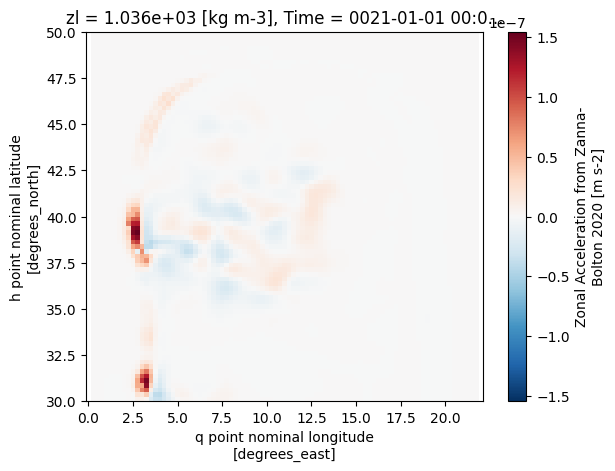

In [256]:
ZB2020u.isel(Time=4,zl=1).plot()

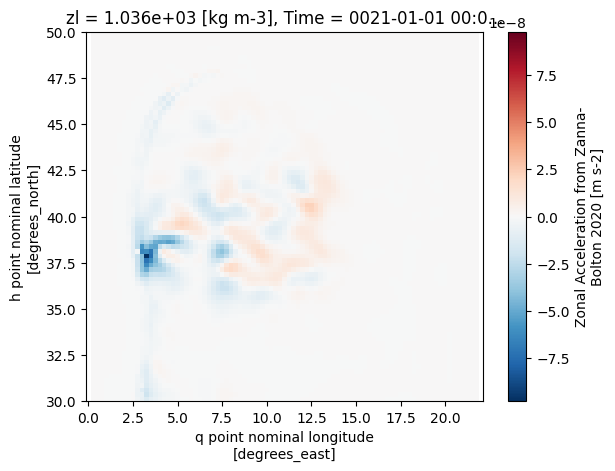

In [257]:
ZB2020u_ANN.isel(Time=4,zl=1).plot()

# Check NW2 online simulations

In [20]:
ds = xr.open_dataset('/scratch/pp2681/mom6/Neverworld2/simulations/R4-ANN/ZB20_ANN/output/ocean.stats.nc', decode_times=False)

In [22]:
smooth = xr.open_dataset('/scratch/pp2681/mom6/Neverworld2/simulations/R4-long/Smooth-filter-3D/output/ocean.stats.nc', decode_times=False)

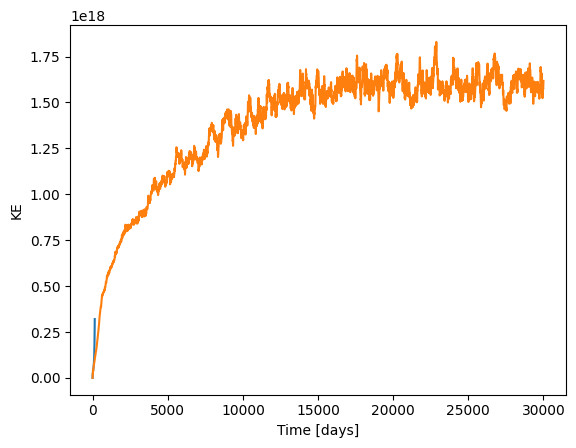

In [23]:
ds.KE.sum('Layer').plot(label='ANN-ZB20-Smooth')
smooth.KE.sum('Layer').plot(label='ZB20-Smooth')

(0.0, 170.0)

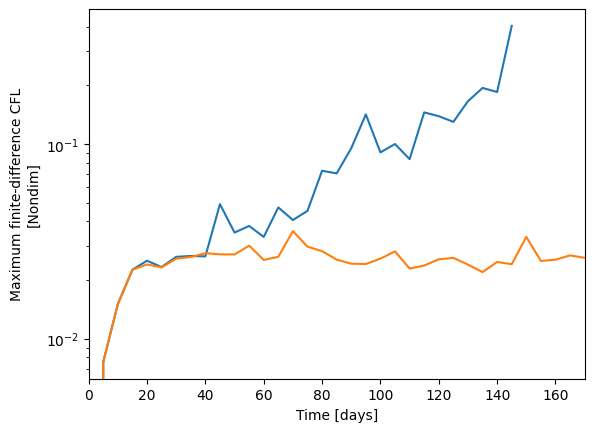

In [34]:
ds.max_CFL_lin.plot(label='ANN-ZB20-Smooth')
smooth.max_CFL_lin.plot(label='ZB20-Smooth')
plt.yscale('log')
plt.xlim([0,170])